In [237]:
import os

# Utilities

In [238]:
def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

# Graph

In [239]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState
from langgraph.graph.message import AnyMessage, add_messages

# class ChatState(TypedDict):
#     messages: Annotated[list[AnyMessage], add_messages]

class ChatState(MessagesState):
    chat_control: Literal["ai", "human_expert"]

In [240]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: ChatState, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            client_id = configuration.get("client_id", None)
            state = {**state, "user_info": client_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

### Primary Assistant

In [241]:
from pydantic import BaseModel, Field

class ToIssueIdentifyingAssistant(BaseModel):
    """Transfers work to a specialized assistant to identify the legal issue to provide information on."""

    request: str = Field(
        description="Any additional information or requests from the user."
    )

class ToEscalationAssistant(BaseModel):
    """Transfers work to an assistant that escalates the issue to a human expert."""

    request: str = Field(
        description="Any additional information or requests from the user."
    )

class ToFormFillingAssistant(BaseModel):
    """Transfers work to a specialized assistant that helps the user fill a legal document."""

    request: str = Field(
        description="Any additional information or requests from the user."
    )

In [242]:
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", temperature=0, api_key=os.getenv("ANTHROPIC_API_KEY"))

primary_assisant_prompt = ChatPromptTemplate(
    [
        ("system",
         """You are a helpful assistant helping a user by helping them get to the right legal aid information and/or help them fill up legal forms. These are your guidelines:
         1. Your primary goal is to converse with the user and help transfer them to the right agent based on what they require. There are four possibilities:
            a. The user needs some legal help. In this case, transfer to the issue identifying agent to help identify the specific legal issue they are facing.
            b. The user needs to fill a legal document/form. In this case, transfer them to the form filling agent.
            c. The user needs to escalate the issue to a human expert. In this case, transfer them to the escalation agent.
            d. The user is just talking without it being clear that they need legal help. In this case, continue the conversation with them.
         2. Do not let the conversation stray off-topic. Do not explicitly mention your role of identifying the agent to transfer to.
         3. Only when you have successfully identified the type of agent to transfer to, call a function to transfer to the appropriate agent. Tell the user that you are transferring them to appropriate resources.
         4. If the user asks for help pertaining to a type outside of the specified types, tell them that you will escalate the issue to a human expert and escalate the conversation to a human."""
         ),
         ("placeholder", "{messages}"),
    ]
)

primary_assisant_tools = [
    ToIssueIdentifyingAssistant,
    ToEscalationAssistant,
    ToFormFillingAssistant
]

primary_assistant_runnable = primary_assisant_prompt | llm.bind_tools(primary_assisant_tools)

### Issue Identifying Assistant

In [243]:
from typing import Literal

class ToLegalInfoAndGuidanceAssistant(BaseModel):
    """Transfers work to a specialized assistant to provide legal aid based on the issue identified."""

    issue: Literal["Housing Disputes", "Wage Theft", "Immigration Concerns"] = Field(
        description="The type of legal issue identified."
    )

In [244]:
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", temperature=0, api_key=os.getenv("ANTHROPIC_API_KEY"))

issue_identifying_prompt = ChatPromptTemplate(
    [
        ("system",
         """You are a helpful assistant helping a user by helping them get to the right legal aid information. These are your guidelines:
         1. Your primary goal is to converse with the user and identify the type of legal help they need. The legal help needed can be one of three types:
            a. Housing Disputes
            b. Wage Theft
            c. Immigration Concerns
         2. Do not let the conversation stray off-topic. Do not explicitly mention your role of identifying the type of legal help needed.
         3. Only when you have successfully identified the type of legal help needed, call a function to transfer to the appropriate legal help agent. Tell the user that you are transferring them to appropriate resources.
         4. If the user asks for help pertaining to a type outside of the specified three types, tell them that you will escalate the issue to a human expert and escalate the conversation to a human."""
         ),
         ("placeholder", "{messages}"),
    ]
)

issue_identifying_assistant_tools = [
    ToLegalInfoAndGuidanceAssistant
]

issue_identifying_assistant_runnable = issue_identifying_prompt | llm.bind_tools(issue_identifying_assistant_tools)

### Form Filling Assistant

In [245]:
from langchain_core.tools import tool
from PyPDF2 import PdfReader, PdfWriter


@tool
def get_pdf_fields(pdf_type: Literal["eviction_response", "wage_claim"])->list[str]:
    """Get the fields of a PDF form to be filled.
    Args:
        pdf_type (Literal["eviction_response", "wage_claim"]): The type of the PDF form.
    Returns:
        list[str]: The fields of the PDF form.
    """

    reader = PdfReader(f"{pdf_type}.pdf")
    return reader.get_fields().keys()

@tool
def fill_pdf_form(pdf_type: Literal["eviction_response", "wage_claim"], field_value_dict: dict)->str:
    """Fill a PDF form with the given field values and return a message indicating the success of the form filling.
    Args:
        pdf_type (Literal["eviction_response", "wage_claim"]): The type of the PDF form.
        field_value_dict (dict): The field values to fill in the PDF form.
    Returns:
        str: A message indicating the success of the form filling.
    """

    # Load the PDF
    reader = PdfReader(f"{pdf_type}.pdf")
    writer = PdfWriter()

    # Copy pages from reader to writer
    for page in reader.pages:
        writer.add_page(page)

    # Fill the form fields
    for field, value in field_value_dict.items():
        writer.update_page_form_field_values(writer.pages[0], {field: value})

    # Save the filled PDF to a new file
    output_pdf_path = f"filled_{pdf_type}.pdf"
    with open(output_pdf_path, "wb") as output_pdf:
        writer.write(output_pdf)

    return f"PDF form filled successfully."

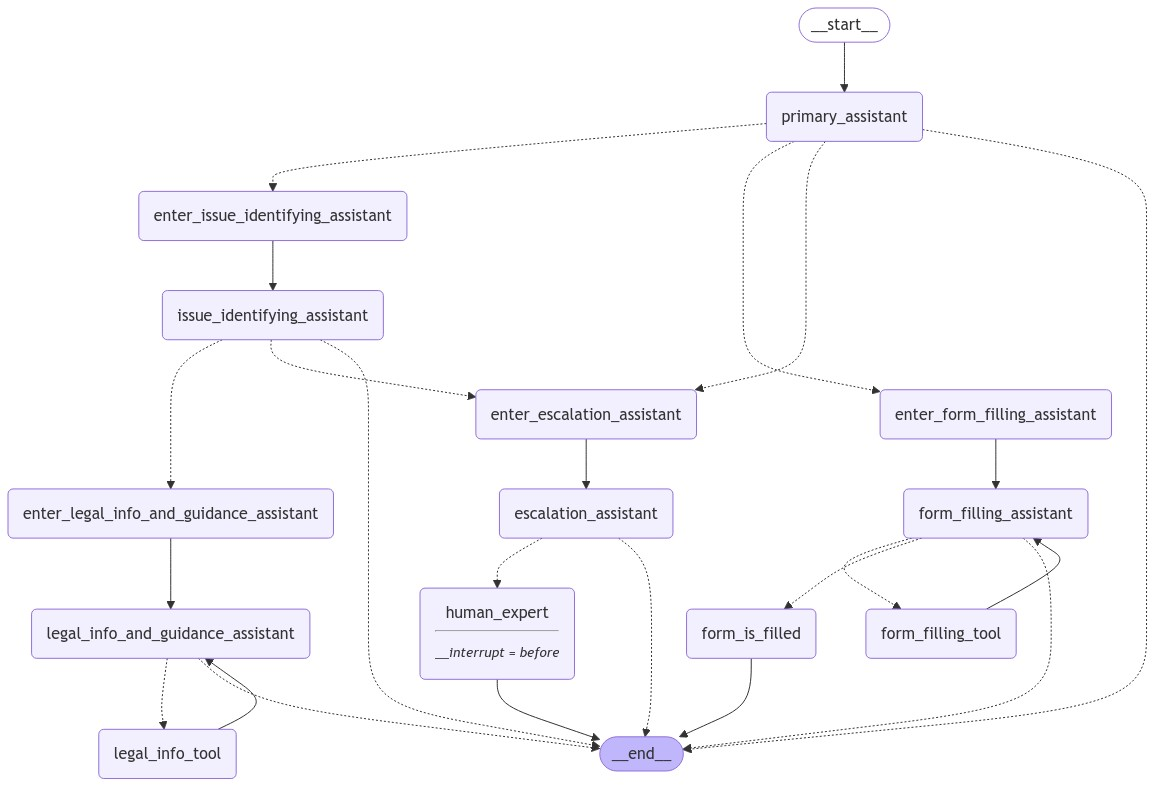

In [74]:
# %%
import os

from dotenv import load_dotenv
load_dotenv()

# %% [markdown]
# # Utilities

# %%
def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

# %% [markdown]
# # Graph

# %%
from typing import Annotated, Literal
from langgraph.graph import MessagesState
from langgraph.graph.message import AnyMessage, add_messages

# class ChatState(TypedDict):
#     messages: Annotated[list[AnyMessage], add_messages]

class ChatState(MessagesState):
    chat_control: Literal["ai", "human_expert"]
    pdf_returned: bool
    pdf_link: str

# %%
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: ChatState, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            client_id = configuration.get("client_id", None)
            state = {**state, "user_info": client_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

# %% [markdown]
# ### Primary Assistant

# %%
from pydantic import BaseModel, Field

class ToIssueIdentifyingAssistant(BaseModel):
    """Transfers work to a specialized assistant to identify the legal issue to provide information on."""

    request: str = Field(
        description="Any additional information or requests from the user."
    )

class ToEscalationAssistant(BaseModel):
    """Transfers work to an assistant that escalates the issue to a human expert."""

    request: str = Field(
        description="Any additional information or requests from the user."
    )

class ToFormFillingAssistant(BaseModel):
    """Transfers work to a specialized assistant that helps the user fill a legal document."""

    request: str = Field(
        description="Any additional information or requests from the user."
    )

# %%
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", temperature=0, api_key=os.getenv("ANTHROPIC_API_KEY"))

primary_assisant_prompt = ChatPromptTemplate(
    [
        ("system",
         """You are a helpful assistant helping a user by helping them get to the right legal aid information and/or help them fill up legal forms. These are your guidelines:
         1. Your primary goal is to converse with the user and help transfer them to the right agent based on what they require. There are four possibilities:
            a. The user needs some legal help. In this case, transfer to the issue identifying agent to help identify the specific legal issue they are facing.
            b. The user needs to fill a legal document/form. In this case, transfer them to the form filling agent.
            c. The user needs to escalate the issue to a human expert. In this case, transfer them to the escalation agent.
            d. The user is just talking without it being clear that they need legal help. In this case, continue the conversation with them.
         2. Do not let the conversation stray off-topic. Do not explicitly mention your role of identifying the agent to transfer to.
         3. Only when you have successfully identified the type of agent to transfer to, call a function to transfer to the appropriate agent. Tell the user that you are transferring them to appropriate resources.
         4. If the user asks for help pertaining to a type outside of the specified types, tell them that you will escalate the issue to a human expert and escalate the conversation to a human.
         5. If the form filling assistant is in the middle of filling a form, keep transferring to the form filling assistant till the form is completely filled."""
         ),
         ("placeholder", "{messages}"),
    ]
)

primary_assisant_tools = [
    ToIssueIdentifyingAssistant,
    ToEscalationAssistant,
    ToFormFillingAssistant
]

primary_assistant_runnable = primary_assisant_prompt | llm.bind_tools(primary_assisant_tools)

# %% [markdown]
# ### Issue Identifying Assistant

# %%
from typing import Literal

class ToLegalInfoAndGuidanceAssistant(BaseModel):
    """Transfers work to a specialized assistant to provide legal aid based on the issue identified."""

    issue: Literal["Housing Disputes", "Wage Theft", "Immigration Concerns"] = Field(
        description="The type of legal issue identified."
    )

# %%
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", temperature=0, api_key=os.getenv("ANTHROPIC_API_KEY"))

issue_identifying_prompt = ChatPromptTemplate(
    [
        ("system",
         """You are a helpful assistant helping a user by helping them get to the right legal aid information. These are your guidelines:
         1. Your primary goal is to converse with the user and identify the type of legal help they need. The legal help needed can be one of three types:
            a. Housing Disputes
            b. Wage Theft
            c. Immigration Concerns
         2. Do not let the conversation stray off-topic. Do not explicitly mention your role of identifying the type of legal help needed.
         3. Only when you have successfully identified the type of legal help needed, call a function to transfer to the appropriate legal help agent. Tell the user that you are transferring them to appropriate resources.
         4. If the user asks for help pertaining to a type outside of the specified three types, tell them that you will escalate the issue to a human expert and escalate the conversation to a human."""
         ),
         ("placeholder", "{messages}"),
    ]
)

issue_identifying_assistant_tools = [
    ToLegalInfoAndGuidanceAssistant
]

issue_identifying_assistant_runnable = issue_identifying_prompt | llm.bind_tools(issue_identifying_assistant_tools)

# %% [markdown]
# ### Form Filling Assistant

# %%
from langchain_core.tools import tool
import fitz
from google.cloud import storage


@tool
def get_pdf_fields(pdf_type: Literal["eviction_response", "wage_claim"]) -> list[str]:
    """Get the fields of a PDF form to be filled.
    Args:
        pdf_type (Literal["eviction_response", "wage_claim"]): The type of the PDF form.
    Returns:
        list[str]: The fields of the PDF form.
    """

    def get_fields(pdf_document):
        # Extract field names, current values, and allowed values
        fields = []
        for page_num in range(len(pdf_document)):
            page = pdf_document[page_num]
            for widget in page.widgets():
                field_name = widget.field_name

                if("#pageSet" in field_name):
                    continue

                allowed_values = None

                if widget.field_type_string == "CheckBox":
                    allowed_values = widget.button_states()['normal']
                elif widget.field_type_string == "ComboBox":
                    allowed_values = widget.choice_values

                fields.append({
                    "field_type": widget.field_type_string,
                    "field_name": field_name,
                    "field_label": widget.field_label,
                    "field_value": widget.field_value or "",
                    "allowed_values": allowed_values
                })

        return fields

    pdf_path = f"{pdf_type}.pdf"
    pdf_document = fitz.open(pdf_path)
    fields = get_fields(pdf_document)
    return [field["field_name"] for field in fields]


@tool
def fill_pdf_form(pdf_type: Literal["eviction_response", "wage_claim"], field_value_dict: dict) -> str:
    """Fill a PDF form with the given field values and return a message indicating the success of the form filling. PDF is only filled when all required values have been provided.
    Args:
        pdf_type (Literal["eviction_response", "wage_claim"]): The type of the PDF form.
        field_value_dict (dict): The field values to fill in the PDF form.
    Returns:
        str: A link to the pdf that was successfully filled.
    """


    def get_fields(pdf_document):
        # Extract field names, current values, and allowed values
        fields = []
        for page_num in range(len(pdf_document)):
            page = pdf_document[page_num]
            for widget in page.widgets():
                field_name = widget.field_name

                if("#pageSet" in field_name):
                    continue

                allowed_values = None

                if widget.field_type_string == "CheckBox":
                    allowed_values = widget.button_states()['normal']
                elif widget.field_type_string == "ComboBox":
                    allowed_values = widget.choice_values

                fields.append({
                    "field_type": widget.field_type_string,
                    "field_name": field_name,
                    "field_label": widget.field_label,
                    "field_value": widget.field_value or "",
                    "allowed_values": allowed_values
                })

        return fields
    
    def write_to_pdf(pdf_document, fields):
        with fitz.open(pdf_document) as doc:
            for page in doc: 
                widgets = page.widgets()
                for widget in widgets:
                    matching_field = [field for field in fields if field["field_name"] == widget.field_name]

                    if(len(matching_field) == 0):
                        continue
                    
                    field = matching_field[0]
                    widget.field_value = field["value"]
                    widget.update()
            doc.saveIncr()
    
    def upload_to_google_cloud_storage(project_id, pdf_document, bucket_name, blob_name):
        storage_client = storage.Client(project=project_id)
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(blob_name)
        blob.upload_from_filename(pdf_document)

            # Construct and return the public URL
        public_url = f"https://storage.googleapis.com/{bucket_name}/{blob_name}"
        return public_url


    pdf_path = f"{pdf_type}.pdf"
    pdf_document = fitz.open(pdf_path)
    fields = get_fields(pdf_document)

    # Update fields with provided values
    for field in fields:
        if field["field_name"] in field_value_dict:
            field["value"] = field_value_dict[field["field_name"]]
        else:
            field["value"] = ""

    write_to_pdf(pdf_path, fields)
    pdf_link = upload_to_google_cloud_storage("justist-ai", pdf_path, "justis", f"{pdf_type}_filled.pdf")
    return pdf_link

class ToFormIsFilled(BaseModel):
    """Supposed to transfer here when the PDF form is filled successfully."""

    form_filled: bool = Field(
        description="Whether the form is filled or not."
    )
    pdf_link: str = Field(
        description="The link to the filled pdf form."
    )

# %%
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", temperature=0, api_key=os.getenv("ANTHROPIC_API_KEY"))

form_filling_assistant_prompt = ChatPromptTemplate(
    [
        ("system",
         """You are a helpful assistant helping a user by guiding them through filling a legal form/document and filling it for them. 
         1. Help a user fill a legal form/document by following these steps:
            a. Identify which form/document needs to be filled and call a function to get back the fields that need to be filled.
            b. Converse with the user and ask for the necessary information required to fill the form.
            c. Fill the form with the information provided by the user.
            d. Once the form is filled, tell the user that the form has been filled and you are providing them with the filled form.
         2. Do not let the conversation stray off-topic. Do not explicitly mention your role as the form filling assistant."""
         ),
         ("placeholder", "{messages}"),
    ]
)

form_filling_assistant_tools = [
    get_pdf_fields,
    fill_pdf_form,
    ToFormIsFilled
]

form_filling_assistant_runnable = form_filling_assistant_prompt | llm.bind_tools(form_filling_assistant_tools)

# %% [markdown]
# ### Legal Info and Guidance Assistant

# %%
# from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchResults
import requests
from bs4 import BeautifulSoup
import urllib
import math

@tool
def legal_info_getter(search_query: str)->str:
    """Get legal information based on the search query.
    Args:
        search_query (str): The search query.
    Returns:
        str: The search results containing legal information.
    """

#     search_engine = DuckDuckGoSearchResults()

#     return search_engine.invoke(search_query)

# def get_legal_info(search_query):

    query = search_query
    def get_search_results(query, num_pages=5):
        """Retrieve links to articles from search results for the query."""
        
        
        base_url = "https://www.law.cornell.edu"
        search_url_template = f"{base_url}/search/wex/{{query}}?page={{page}}"

        article_links = []
        for page in range(num_pages):
            search_url = search_url_template.format(query=query, page=page)
            response = requests.get(search_url)
            if response.status_code != 200:
                print(f"Failed to retrieve page {page + 1} of search results.")
                continue
            soup = BeautifulSoup(response.text, "html.parser")
            # Find all search result items in the page
            results = soup.select("li.search-result h3.title a")
            # Extract the href attribute for each result
            for result in results:
                article_links.append(result["href"])
            # time.sleep(1)  # Pause to avoid overloading the server
        return article_links

    def get_article_content(url):
        """Retrieve and parse the main content from an article page."""
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Failed to retrieve article at {url}")
            return None
        soup = BeautifulSoup(response.text, "html.parser")
        # Extract the main content from the article page
        main_content_div = soup.find("div", id="main-content")
        if not main_content_div:
            return None
        content = []
        # Extract paragraphs within the main content div
        for paragraph in main_content_div.find_all("p"):
            content.append(paragraph.get_text())
        return "\n".join(content)

    def legal_info_call(query):
        """Perform the search and retrieve the content of the top articles."""
        
        num_articles = 10
        # Step 1: Get the search results (first num_articles results)
        article_links = get_search_results(query, num_pages=math.ceil(num_articles / 10))

        # Step 2: Extract content from each article
        articles_content = {}
        for link in article_links:
            print(f"Retrieving content from {link}")
            content = get_article_content(link)
            if content:
                articles_content[link] = content
            # time.sleep(1)  # Pause to avoid overloading the server

        return articles_content
    
    articles = legal_info_call(urllib.parse.quote_plus(query))

    send_string= ""
    
    for url, content in articles.items():
        send_string+=content

    return send_string

# %%
legal_info_and_guidance_prompt = ChatPromptTemplate(
    [
        ("system",
         """You are a helpful assistant providing legal aid information based on the user's query. 
         1. Understand the user's legal information needs based on the conversation.
         2. Use the provided tool to appropriately search for legal information based on the user's needs.
         3. Provide the user with the relevant legal information obtained from the search.
         4. Do not let the conversation stray off-topic. Do not explicitly mention your role as the legal information assistant."""
         ),
         ("placeholder", "{messages}"),
    ]
)

legal_info_and_guidance_tools = [
    legal_info_getter
]

legal_info_and_guidance_runnable = legal_info_and_guidance_prompt | llm.bind_tools(legal_info_and_guidance_tools)

# %% [markdown]
# ### Escalation Assistant

# %%
class EscalationAssistant(Assistant):
    def __call__(self, state: ChatState, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            client_id = configuration.get("client_id", None)
            state = {**state, "user_info": client_id}
            result = self.runnable.invoke(state)
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result, "chat_control": "human_expert"}

# %%
class ToHumanExpert(BaseModel):
    """Transfers work to the human expert, provides them a summary of the conversation so far."""

    summary: str = Field(
        description="Summary of the conversation so far."
    )

# %%
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", temperature=0, api_key=os.getenv("ANTHROPIC_API_KEY"))

escalation_assistant_prompt = ChatPromptTemplate(
    [
        ("system",
         """You are a helpful assistant that escalates the issue to a human expert by summarizing the conversation so far. 
         1. Summarize the conversation with the user.
         2. Provide the summary to a human expert for further assistance.
         3. Inform the user that their issue is being escalated to a human expert."""
         ),
         ("placeholder", "{messages}"),
    ]
)

escalation_assistant_tools = [
    ToHumanExpert
]

escalation_assistant_runnable = escalation_assistant_prompt | llm.bind_tools(escalation_assistant_tools)

# %% [markdown]
# ### Human Node

# %%
def human_node(state: ChatState)->ChatState:
    return {"chat_control": "ai"}

# %% [markdown]
# ### Graph building

# %%
from typing import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str) -> Callable:
    def entry_node(state: ChatState) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}."
                    "Reflect on the above conversation between the host assistant and the user."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ]
        }

    return entry_node

# %%
from langgraph.prebuilt import tools_condition
from langgraph.graph import END, StateGraph, START

def cond_edge_router(
    state: ChatState,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToEscalationAssistant.__name__:
            return "enter_escalation_assistant"
        elif tool_calls[0]["name"] == ToIssueIdentifyingAssistant.__name__:
            return "enter_issue_identifying_assistant"
        elif tool_calls[0]["name"] == ToFormFillingAssistant.__name__:
            return "enter_form_filling_assistant"
        elif tool_calls[0]["name"] == ToLegalInfoAndGuidanceAssistant.__name__:
            return "enter_legal_info_and_guidance_assistant"
        elif tool_calls[0]["name"] == ToHumanExpert.__name__:
            return "human_expert"

    # raise ValueError("Invalid route")

def custom_tools_condition(state: ChatState):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"]=="legal_info_getter":
            return "legal_info_tool"
        elif tool_calls[0]["name"]==ToFormIsFilled.__name__:
            return "form_is_filled"
        elif tool_calls[0]["name"]=="get_pdf_fields" or tool_calls[0]["name"]=="fill_pdf_form":
            return "form_filling_tool"
    
    raise ValueError("Invalid route")

def form_is_filled_node(state: ChatState)->ChatState:
    return {"pdf_returned": True, "pdf_link": state['messages'][-1].tool_calls[0]['args']['pdf_link']}
# "pdf_link": state["messages"].content
# %%
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(ChatState)

builder.add_node("primary_assistant", Assistant(primary_assistant_runnable))
builder.add_node("enter_issue_identifying_assistant", create_entry_node("Issue Identifying Assistant"))
builder.add_node("issue_identifying_assistant", Assistant(issue_identifying_assistant_runnable))
builder.add_node("enter_legal_info_and_guidance_assistant", create_entry_node("Legal Info and Guidance Assistant"))
builder.add_node("legal_info_and_guidance_assistant", Assistant(legal_info_and_guidance_runnable))
builder.add_node("legal_info_tool", ToolNode(legal_info_and_guidance_tools))
builder.add_node("enter_form_filling_assistant", create_entry_node("Form Filling Assistant"))
builder.add_node("form_filling_assistant", Assistant(form_filling_assistant_runnable))
builder.add_node("form_is_filled", form_is_filled_node)
builder.add_node("form_filling_tool", ToolNode(form_filling_assistant_tools))
builder.add_node("enter_escalation_assistant", create_entry_node("Escalation Assistant"))
builder.add_node("escalation_assistant", Assistant(escalation_assistant_runnable))
builder.add_node("human_expert", human_node)

builder.add_edge(START, "primary_assistant")
builder.add_conditional_edges("primary_assistant", cond_edge_router, ["enter_issue_identifying_assistant", "enter_form_filling_assistant", "enter_escalation_assistant", END])
builder.add_conditional_edges("issue_identifying_assistant", cond_edge_router, ["enter_legal_info_and_guidance_assistant", "enter_escalation_assistant", END])
builder.add_conditional_edges("legal_info_and_guidance_assistant", custom_tools_condition, ["legal_info_tool", END])
builder.add_edge("legal_info_tool", "legal_info_and_guidance_assistant")
builder.add_conditional_edges("form_filling_assistant", custom_tools_condition, ["form_filling_tool", "form_is_filled", END])
builder.add_edge("form_filling_tool", "form_filling_assistant")
builder.add_edge("form_is_filled", END)
builder.add_edge("enter_issue_identifying_assistant", "issue_identifying_assistant")
builder.add_edge("enter_legal_info_and_guidance_assistant", "legal_info_and_guidance_assistant")
builder.add_edge("enter_form_filling_assistant", "form_filling_assistant")
builder.add_edge("enter_escalation_assistant", "escalation_assistant")
builder.add_conditional_edges("escalation_assistant", cond_edge_router, ["human_expert", END])
builder.add_edge("human_expert", END)

memory=MemorySaver()
justis_ai_graph = builder.compile(checkpointer=memory, interrupt_before=["human_expert"])
# justis_ai_graph = builder.compile()


# %%
from IPython.display import Image, display

try:
    display(Image(justis_ai_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass



### Legal Info and Guidance Assistant

In [247]:
from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchResults

@tool
def legal_info_getter(search_query: str):
    """Get legal information based on the search query.
    Args:
        search_query (str): The search query.
    Returns:
        str: The search results containing legal information.
    """

    search_engine = DuckDuckGoSearchResults()

    return search_engine.invoke(search_query)

In [248]:
legal_info_and_guidance_prompt = ChatPromptTemplate(
    [
        ("system",
         """You are a helpful assistant providing legal aid information based on the user's query. 
         1. Understand the user's legal information needs based on the conversation.
         2. Use the provided tool to appropriately search for legal information based on the user's needs.
         3. Provide the user with the relevant legal information obtained from the search.
         4. Do not let the conversation stray off-topic. Do not explicitly mention your role as the legal information assistant."""
         ),
         ("placeholder", "{messages}"),
    ]
)

legal_info_and_guidance_tools = [
    legal_info_getter
]

legal_info_and_guidance_runnable = legal_info_and_guidance_prompt | llm.bind_tools(legal_info_and_guidance_tools)

### Escalation Assistant

In [249]:
class EscalationAssistant(Assistant):
    def __call__(self, state: ChatState, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            client_id = configuration.get("client_id", None)
            state = {**state, "user_info": client_id}
            result = self.runnable.invoke(state)
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result, "chat_control": "human_expert"}

In [250]:
class ToHumanExpert(BaseModel):
    """Transfers work to the human expert, provides them a summary of the conversation so far."""

    summary: str = Field(
        description="Summary of the conversation so far."
    )

In [251]:
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", temperature=0, api_key=os.getenv("ANTHROPIC_API_KEY"))

escalation_assistant_prompt = ChatPromptTemplate(
    [
        ("system",
         """You are a helpful assistant that escalates the issue to a human expert by summarizing the conversation so far. 
         1. Summarize the conversation with the user.
         2. Provide the summary to a human expert for further assistance.
         3. Inform the user that their issue is being escalated to a human expert."""
         ),
         ("placeholder", "{messages}"),
    ]
)

escalation_assistant_tools = [
    ToHumanExpert
]

escalation_assistant_runnable = escalation_assistant_prompt | llm.bind_tools(escalation_assistant_tools)

### Human Node

In [252]:
def human_node(state: ChatState)->ChatState:
    return {"chat_control": "ai"}

### Graph building

In [253]:
from typing import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str) -> Callable:
    def entry_node(state: ChatState) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}."
                    "Reflect on the above conversation between the host assistant and the user."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ]
        }

    return entry_node

In [17]:
from langgraph.prebuilt import tools_condition
from langgraph.graph import END, StateGraph, START

def cond_edge_router(
    state: ChatState,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToEscalationAssistant.__name__:
            return "enter_escalation_assistant"
        elif tool_calls[0]["name"] == ToIssueIdentifyingAssistant.__name__:
            return "enter_issue_identifying_assistant"
        elif tool_calls[0]["name"] == ToFormFillingAssistant.__name__:
            return "enter_form_filling_assistant"
        elif tool_calls[0]["name"] == ToLegalInfoAndGuidanceAssistant.__name__:
            return "enter_legal_info_and_guidance_assistant"
        elif tool_calls[0]["name"] == ToHumanExpert.__name__:
            return "human_expert"

    raise ValueError("Invalid route")

def custom_tools_condition(state: ChatState):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"]=="legal_info_getter":
            return "legal_info_tool"
        elif tool_calls[0]["name"]=="get_pdf_fields" or tool_calls[0]["name"]=="fill_pdf_form":
            return "form_filling_tool"
    
    raise ValueError("Invalid route")

In [255]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(ChatState)

builder.add_node("primary_assistant", Assistant(primary_assistant_runnable))
builder.add_node("enter_issue_identifying_assistant", create_entry_node("Issue Identifying Assistant"))
builder.add_node("issue_identifying_assistant", Assistant(issue_identifying_assistant_runnable))
builder.add_node("enter_legal_info_and_guidance_assistant", create_entry_node("Legal Info and Guidance Assistant"))
builder.add_node("legal_info_and_guidance_assistant", Assistant(legal_info_and_guidance_runnable))
builder.add_node("legal_info_tool", ToolNode(legal_info_and_guidance_tools))
builder.add_node("enter_form_filling_assistant", create_entry_node("Form Filling Assistant"))
builder.add_node("form_filling_assistant", Assistant(form_filling_assistant_runnable))
builder.add_node("form_filling_tool", ToolNode(form_filling_assistant_tools))
builder.add_node("enter_escalation_assistant", create_entry_node("Escalation Assistant"))
builder.add_node("escalation_assistant", Assistant(escalation_assistant_runnable))
builder.add_node("human_expert", human_node)

builder.add_edge(START, "primary_assistant")
builder.add_conditional_edges("primary_assistant", cond_edge_router, ["enter_issue_identifying_assistant", "enter_form_filling_assistant", "enter_escalation_assistant", END])
builder.add_conditional_edges("issue_identifying_assistant", cond_edge_router, ["enter_legal_info_and_guidance_assistant", "enter_escalation_assistant"])
builder.add_conditional_edges("legal_info_and_guidance_assistant", custom_tools_condition, ["legal_info_tool", END])
builder.add_edge("legal_info_tool", "legal_info_and_guidance_assistant")
builder.add_conditional_edges("form_filling_assistant", custom_tools_condition, ["form_filling_tool", END])
builder.add_edge("form_filling_tool", "form_filling_assistant")
builder.add_edge("enter_issue_identifying_assistant", "issue_identifying_assistant")
builder.add_edge("enter_legal_info_and_guidance_assistant", "legal_info_and_guidance_assistant")
builder.add_edge("enter_form_filling_assistant", "form_filling_assistant")
builder.add_edge("enter_escalation_assistant", "escalation_assistant")
builder.add_conditional_edges("escalation_assistant", cond_edge_router, ["human_expert", END])
builder.add_edge("human_expert", END)

memory=MemorySaver()
justis_ai_graph = builder.compile(checkpointer=memory, interrupt_before=["human_expert"])

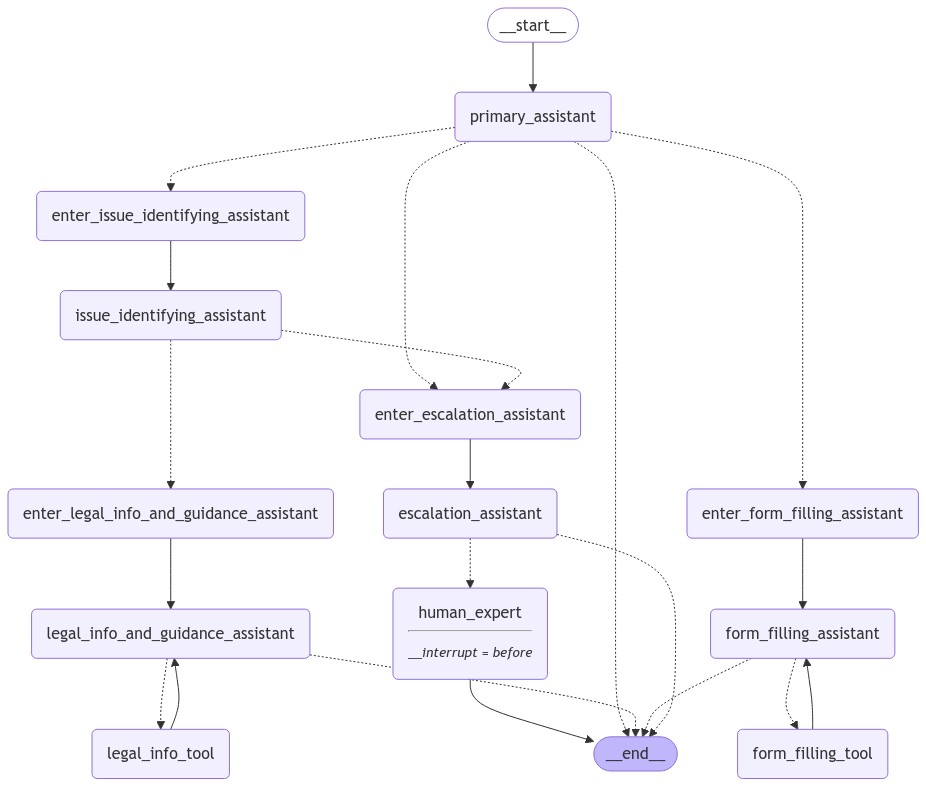

In [256]:
from IPython.display import Image, display

try:
    display(Image(justis_ai_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Run

In [220]:
import uuid

questions = [
    "Hi!",
    "Can you help me with something?",
    "I just got evicted by my landlord and I think it was unfair.",
]

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "client_id": "1234",
        "thread_id": thread_id,
    }
}

_printed = set()

for i, question in enumerate(questions):
    if i==0:
        events = justis_ai_graph.stream(
        {"messages": ("user", question), "chat_control": "ai"}, config, stream_mode="values"
        )
    else:
        events = justis_ai_graph.stream(
            {"messages": ("user", question)}, config, stream_mode="values"
        )

    for event in events:
        _print_event(event, _printed)
        print(event)

================================ Human Message =================================

Hi!
{'messages': [HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}, id='0516a16c-4fe2-4900-8889-1f08bc6b069a')], 'chat_control': 'ai'}
================================== Ai Message ==================================

Hello! How can I assist you today? Feel free to tell me about any legal questions or concerns you have, or if you need help with any legal documents.
{'messages': [HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}, id='0516a16c-4fe2-4900-8889-1f08bc6b069a'), AIMessage(content='Hello! How can I assist you today? Feel free to tell me about any legal questions or concerns you have, or if you need help with any legal documents.', additional_kwargs={}, response_metadata={'id': 'msg_01XSZmWTPXjcgAdkY5WCccek', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 864, 'output_tokens': 36}}, id='ru

In [221]:

question = ["I don't like you. I want to talk to a human."]

for event in justis_ai_graph.stream({"messages": ("user", question)}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

["I don't like you. I want to talk to a human."]
================================== Ai Message ==================================

[{'text': "I understand that you'd prefer to speak with a human about your situation. I'll help connect you with a human expert who can assist you with your eviction case.", 'type': 'text'}, {'id': 'toolu_01FRr5jYZqJg7oSa1r9uiGdB', 'input': {'request': 'User is dealing with an eviction case and has requested to speak with a human expert directly.'}, 'name': 'ToEscalationAssistant', 'type': 'tool_use'}]
Tool Calls:
  ToEscalationAssistant (toolu_01FRr5jYZqJg7oSa1r9uiGdB)
 Call ID: toolu_01FRr5jYZqJg7oSa1r9uiGdB
  Args:
    request: User is dealing with an eviction case and has requested to speak with a human expert directly.
================================= Tool Message =================================

The assistant is now the Escalation Assistant.Reflect on the above conver

In [227]:
justis_ai_graph.update_state(config, {'messages': [("human", "Hey here is the correct info"), ("user", "Thanks!")]})

{'configurable': {'thread_id': 'f1c4d965-f0d0-4293-b685-33e6a531c835',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef936ac-143d-6cf2-8013-522ee90a1a35'}}

In [257]:
justis_ai_graph.get_state(config)

StateSnapshot(values={}, next=(), config={'configurable': {'client_id': '1234', 'thread_id': 'f1c4d965-f0d0-4293-b685-33e6a531c835'}}, metadata=None, created_at=None, parent_config=None, tasks=())

In [235]:
for event in justis_ai_graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Thanks!


In [236]:
justis_ai_graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}, id='0516a16c-4fe2-4900-8889-1f08bc6b069a'), AIMessage(content='Hello! How can I assist you today? Feel free to tell me about any legal questions or concerns you have, or if you need help with any legal documents.', additional_kwargs={}, response_metadata={'id': 'msg_01XSZmWTPXjcgAdkY5WCccek', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 864, 'output_tokens': 36}}, id='run-060cfed4-f363-4d41-8cbb-78870ea917d5-0', usage_metadata={'input_tokens': 864, 'output_tokens': 36, 'total_tokens': 900, 'input_token_details': {}}), HumanMessage(content='Can you help me with something?', additional_kwargs={}, response_metadata={}, id='48a1d2a3-da17-4117-b935-06a0c9221a8b'), AIMessage(content="Of course! I'd be happy to help. Could you please tell me more about what kind of help you're looking for? For example:\n- Do you have a

# EVERYTHNG

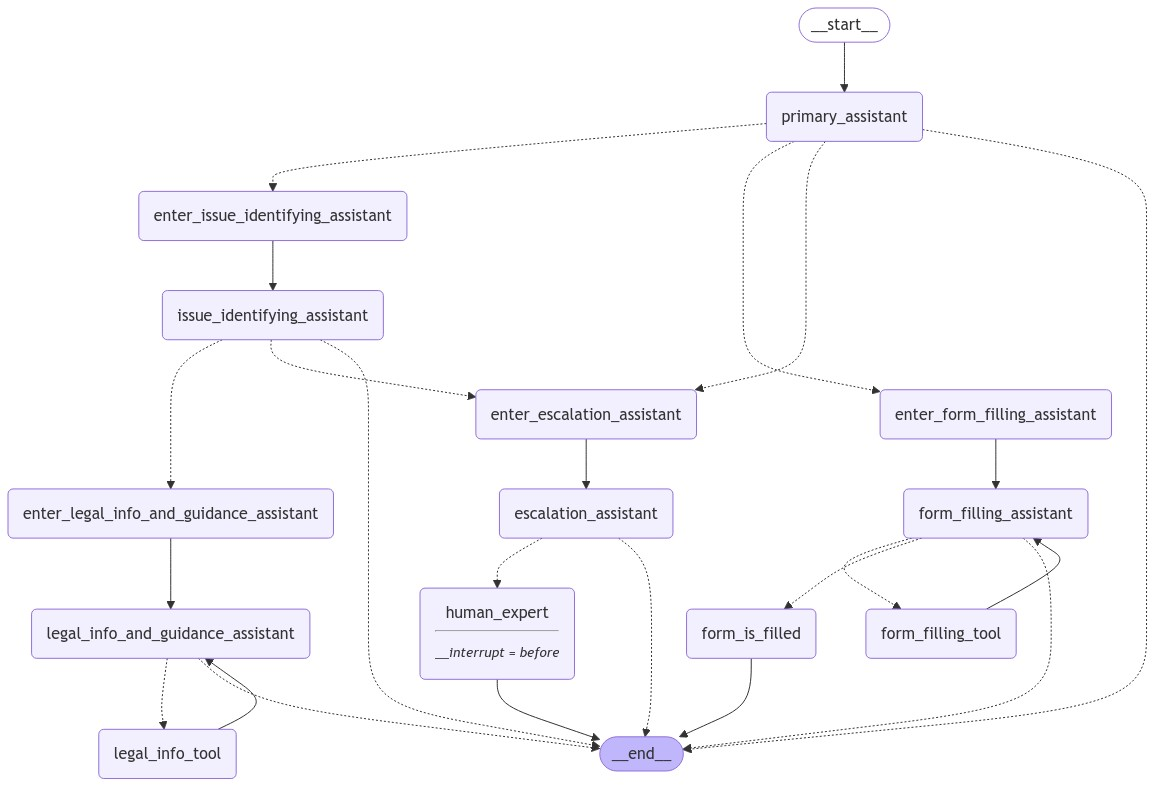

In [7]:
# %%
import os

from dotenv import load_dotenv
load_dotenv()

# %% [markdown]
# # Utilities

# %%
def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

# %% [markdown]
# # Graph

# %%
from typing import Annotated, Literal
from langgraph.graph import MessagesState
from langgraph.graph.message import AnyMessage, add_messages

# class ChatState(TypedDict):
#     messages: Annotated[list[AnyMessage], add_messages]

class ChatState(MessagesState):
    chat_control: Literal["ai", "human_expert"]
    pdf_returned: bool
    pdf_link: str

# %%
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: ChatState, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            client_id = configuration.get("client_id", None)
            state = {**state, "user_info": client_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

# %% [markdown]
# ### Primary Assistant

# %%
from pydantic import BaseModel, Field

class ToIssueIdentifyingAssistant(BaseModel):
    """Transfers work to a specialized assistant to identify the legal issue to provide information on."""

    request: str = Field(
        description="Any additional information or requests from the user."
    )

class ToEscalationAssistant(BaseModel):
    """Transfers work to an assistant that escalates the issue to a human expert."""

    request: str = Field(
        description="Any additional information or requests from the user."
    )

class ToFormFillingAssistant(BaseModel):
    """Transfers work to a specialized assistant that helps the user fill a legal document."""

    request: str = Field(
        description="Any additional information or requests from the user."
    )

# %%
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", temperature=0, api_key=os.getenv("ANTHROPIC_API_KEY"))

primary_assisant_prompt = ChatPromptTemplate(
    [
        ("system",
         """You are a helpful assistant helping a user by helping them get to the right legal aid information and/or help them fill up legal forms. These are your guidelines:
         1. Your primary goal is to converse with the user and help transfer them to the right agent based on what they require. There are four possibilities:
            a. The user needs some legal help. In this case, transfer to the issue identifying agent to help identify the specific legal issue they are facing.
            b. The user needs to fill a legal document/form. In this case, transfer them to the form filling agent.
            c. The user needs to escalate the issue to a human expert. In this case, transfer them to the escalation agent.
            d. The user is just talking without it being clear that they need legal help. In this case, continue the conversation with them.
         2. Do not let the conversation stray off-topic. Do not explicitly mention your role of identifying the agent to transfer to.
         3. Only when you have successfully identified the type of agent to transfer to, call a function to transfer to the appropriate agent. Tell the user that you are transferring them to appropriate resources.
         4. If the user asks for help pertaining to a type outside of the specified types, tell them that you will escalate the issue to a human expert and escalate the conversation to a human.
         5. If the form filling assistant is in the middle of filling a form, keep transferring to the form filling assistant till the form is completely filled."""
         ),
         ("placeholder", "{messages}"),
    ]
)

primary_assisant_tools = [
    ToIssueIdentifyingAssistant,
    ToEscalationAssistant,
    ToFormFillingAssistant
]

primary_assistant_runnable = primary_assisant_prompt | llm.bind_tools(primary_assisant_tools)

# %% [markdown]
# ### Issue Identifying Assistant

# %%
from typing import Literal

class ToLegalInfoAndGuidanceAssistant(BaseModel):
    """Transfers work to a specialized assistant to provide legal aid based on the issue identified."""

    issue: Literal["Housing Disputes", "Wage Theft", "Immigration Concerns"] = Field(
        description="The type of legal issue identified."
    )

# %%
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", temperature=0, api_key=os.getenv("ANTHROPIC_API_KEY"))

issue_identifying_prompt = ChatPromptTemplate(
    [
        ("system",
         """You are a helpful assistant helping a user by helping them get to the right legal aid information. These are your guidelines:
         1. Your primary goal is to converse with the user and identify the type of legal help they need. The legal help needed can be one of three types:
            a. Housing Disputes
            b. Wage Theft
            c. Immigration Concerns
         2. Do not let the conversation stray off-topic. Do not explicitly mention your role of identifying the type of legal help needed.
         3. Only when you have successfully identified the type of legal help needed, call a function to transfer to the appropriate legal help agent. Tell the user that you are transferring them to appropriate resources.
         4. If the user asks for help pertaining to a type outside of the specified three types, tell them that you will escalate the issue to a human expert and escalate the conversation to a human."""
         ),
         ("placeholder", "{messages}"),
    ]
)

issue_identifying_assistant_tools = [
    ToLegalInfoAndGuidanceAssistant
]

issue_identifying_assistant_runnable = issue_identifying_prompt | llm.bind_tools(issue_identifying_assistant_tools)

# %% [markdown]
# ### Form Filling Assistant

# %%
from langchain_core.tools import tool
import fitz
from google.cloud import storage


@tool
def get_pdf_fields(pdf_type: Literal["eviction_response", "wage_claim"]) -> list[str]:
    """Get the fields of a PDF form to be filled.
    Args:
        pdf_type (Literal["eviction_response", "wage_claim"]): The type of the PDF form.
    Returns:
        list[str]: The fields of the PDF form.
    """

    def get_fields(pdf_document):
        # Extract field names, current values, and allowed values
        fields = []
        for page_num in range(len(pdf_document)):
            page = pdf_document[page_num]
            for widget in page.widgets():
                field_name = widget.field_name

                if("#pageSet" in field_name):
                    continue

                allowed_values = None

                if widget.field_type_string == "CheckBox":
                    allowed_values = widget.button_states()['normal']
                elif widget.field_type_string == "ComboBox":
                    allowed_values = widget.choice_values

                fields.append({
                    "field_type": widget.field_type_string,
                    "field_name": field_name,
                    "field_label": widget.field_label,
                    "field_value": widget.field_value or "",
                    "allowed_values": allowed_values
                })

        return fields

    pdf_path = f"{pdf_type}.pdf"
    pdf_document = fitz.open(pdf_path)
    fields = get_fields(pdf_document)
    return [field["field_name"] for field in fields]


@tool
def fill_pdf_form(pdf_type: Literal["eviction_response", "wage_claim"], field_value_dict: dict) -> str:
    """Fill a PDF form with the given field values and return a message indicating the success of the form filling. PDF is only filled when all required values have been provided.
    Args:
        pdf_type (Literal["eviction_response", "wage_claim"]): The type of the PDF form.
        field_value_dict (dict): The field values to fill in the PDF form.
    Returns:
        str: A link to the pdf that was successfully filled.
    """


    def get_fields(pdf_document):
        # Extract field names, current values, and allowed values
        fields = []
        for page_num in range(len(pdf_document)):
            page = pdf_document[page_num]
            for widget in page.widgets():
                field_name = widget.field_name

                if("#pageSet" in field_name):
                    continue

                allowed_values = None

                if widget.field_type_string == "CheckBox":
                    allowed_values = widget.button_states()['normal']
                elif widget.field_type_string == "ComboBox":
                    allowed_values = widget.choice_values

                fields.append({
                    "field_type": widget.field_type_string,
                    "field_name": field_name,
                    "field_label": widget.field_label,
                    "field_value": widget.field_value or "",
                    "allowed_values": allowed_values
                })

        return fields
    
    def write_to_pdf(pdf_document, fields):
        with fitz.open(pdf_document) as doc:
            for page in doc: 
                widgets = page.widgets()
                for widget in widgets:
                    matching_field = [field for field in fields if field["field_name"] == widget.field_name]

                    if(len(matching_field) == 0):
                        continue
                    
                    field = matching_field[0]
                    widget.field_value = field["value"]
                    widget.update()
            doc.saveIncr()
    
    def upload_to_google_cloud_storage(project_id, pdf_document, bucket_name, blob_name):
        storage_client = storage.Client(project=project_id)
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(blob_name)
        blob.upload_from_filename(pdf_document)

            # Construct and return the public URL
        public_url = f"https://storage.googleapis.com/{bucket_name}/{blob_name}"
        return public_url


    pdf_path = f"{pdf_type}.pdf"
    pdf_document = fitz.open(pdf_path)
    fields = get_fields(pdf_document)

    # Update fields with provided values
    for field in fields:
        if field["field_name"] in field_value_dict:
            field["value"] = field_value_dict[field["field_name"]]
        else:
            field["value"] = ""

    write_to_pdf(pdf_path, fields)
    pdf_link = upload_to_google_cloud_storage("justist-ai", pdf_path, "justis", f"{pdf_type}_filled.pdf")
    return pdf_link

class ToFormIsFilled(BaseModel):
    """Supposed to transfer here when the PDF form is filled successfully."""

    form_filled: bool = Field(
        description="Whether the form is filled or not."
    )
    pdf_link: str = Field(
        description="The link to the filled pdf form."
    )

# %%
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", temperature=0, api_key=os.getenv("ANTHROPIC_API_KEY"))

form_filling_assistant_prompt = ChatPromptTemplate(
    [
        ("system",
         """You are a helpful assistant helping a user by guiding them through filling a legal form/document and filling it for them. 
         1. Help a user fill a legal form/document by following these steps:
            a. Identify which form/document needs to be filled and call a function to get back the fields that need to be filled.
            b. Converse with the user and ask for the necessary information required to fill the form.
            c. Fill the form with the information provided by the user.
            d. Once the form is filled, tell the user that the form has been filled and you are providing them with the filled form.
         2. Do not let the conversation stray off-topic. Do not explicitly mention your role as the form filling assistant."""
         ),
         ("placeholder", "{messages}"),
    ]
)

form_filling_assistant_tools = [
    get_pdf_fields,
    fill_pdf_form,
    ToFormIsFilled
]

form_filling_assistant_runnable = form_filling_assistant_prompt | llm.bind_tools(form_filling_assistant_tools)

# %% [markdown]
# ### Legal Info and Guidance Assistant

# %%
# from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchResults
import requests
from bs4 import BeautifulSoup
import urllib
import math

@tool
def legal_info_getter(search_query: str)->str:
    """Get legal information based on the search query.
    Args:
        search_query (str): The search query.
    Returns:
        str: The search results containing legal information.
    """

#     search_engine = DuckDuckGoSearchResults()

#     return search_engine.invoke(search_query)

# def get_legal_info(search_query):

    query = search_query
    def get_search_results(query, num_pages=5):
        """Retrieve links to articles from search results for the query."""
        
        
        base_url = "https://www.law.cornell.edu"
        search_url_template = f"{base_url}/search/wex/{{query}}?page={{page}}"

        article_links = []
        for page in range(num_pages):
            search_url = search_url_template.format(query=query, page=page)
            response = requests.get(search_url)
            if response.status_code != 200:
                print(f"Failed to retrieve page {page + 1} of search results.")
                continue
            soup = BeautifulSoup(response.text, "html.parser")
            # Find all search result items in the page
            results = soup.select("li.search-result h3.title a")
            # Extract the href attribute for each result
            for result in results:
                article_links.append(result["href"])
            # time.sleep(1)  # Pause to avoid overloading the server
        return article_links

    def get_article_content(url):
        """Retrieve and parse the main content from an article page."""
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Failed to retrieve article at {url}")
            return None
        soup = BeautifulSoup(response.text, "html.parser")
        # Extract the main content from the article page
        main_content_div = soup.find("div", id="main-content")
        if not main_content_div:
            return None
        content = []
        # Extract paragraphs within the main content div
        for paragraph in main_content_div.find_all("p"):
            content.append(paragraph.get_text())
        return "\n".join(content)

    def legal_info_call(query):
        """Perform the search and retrieve the content of the top articles."""
        
        num_articles = 10
        # Step 1: Get the search results (first num_articles results)
        article_links = get_search_results(query, num_pages=math.ceil(num_articles / 10))

        # Step 2: Extract content from each article
        articles_content = {}
        for link in article_links:
            print(f"Retrieving content from {link}")
            content = get_article_content(link)
            if content:
                articles_content[link] = content
            # time.sleep(1)  # Pause to avoid overloading the server

        return articles_content
    
    articles = legal_info_call(urllib.parse.quote_plus(query))

    send_string= ""
    
    for url, content in articles.items():
        send_string+=content

    return send_string

# %%
legal_info_and_guidance_prompt = ChatPromptTemplate(
    [
        ("system",
         """You are a helpful assistant providing legal aid information based on the user's query. 
         1. Understand the user's legal information needs based on the conversation.
         2. Use the provided tool to appropriately search for legal information based on the user's needs.
         3. Provide the user with the relevant legal information obtained from the search.
         4. Do not let the conversation stray off-topic. Do not explicitly mention your role as the legal information assistant."""
         ),
         ("placeholder", "{messages}"),
    ]
)

legal_info_and_guidance_tools = [
    legal_info_getter
]

legal_info_and_guidance_runnable = legal_info_and_guidance_prompt | llm.bind_tools(legal_info_and_guidance_tools)

# %% [markdown]
# ### Escalation Assistant

# %%
class EscalationAssistant(Assistant):
    def __call__(self, state: ChatState, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            client_id = configuration.get("client_id", None)
            state = {**state, "user_info": client_id}
            result = self.runnable.invoke(state)
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result, "chat_control": "human_expert"}

# %%
class ToHumanExpert(BaseModel):
    """Transfers work to the human expert, provides them a summary of the conversation so far."""

    summary: str = Field(
        description="Summary of the conversation so far."
    )

# %%
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", temperature=0, api_key=os.getenv("ANTHROPIC_API_KEY"))

escalation_assistant_prompt = ChatPromptTemplate(
    [
        ("system",
         """You are a helpful assistant that escalates the issue to a human expert by summarizing the conversation so far. 
         1. Summarize the conversation with the user.
         2. Provide the summary to a human expert for further assistance.
         3. Inform the user that their issue is being escalated to a human expert."""
         ),
         ("placeholder", "{messages}"),
    ]
)

escalation_assistant_tools = [
    ToHumanExpert
]

escalation_assistant_runnable = escalation_assistant_prompt | llm.bind_tools(escalation_assistant_tools)

# %% [markdown]
# ### Human Node

# %%
def human_node(state: ChatState)->ChatState:
    return {"chat_control": "ai"}

# %% [markdown]
# ### Graph building

# %%
from typing import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str) -> Callable:
    def entry_node(state: ChatState) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}."
                    "Reflect on the above conversation between the host assistant and the user."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ]
        }

    return entry_node

# %%
from langgraph.prebuilt import tools_condition
from langgraph.graph import END, StateGraph, START

def cond_edge_router(
    state: ChatState,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToEscalationAssistant.__name__:
            return "enter_escalation_assistant"
        elif tool_calls[0]["name"] == ToIssueIdentifyingAssistant.__name__:
            return "enter_issue_identifying_assistant"
        elif tool_calls[0]["name"] == ToFormFillingAssistant.__name__:
            return "enter_form_filling_assistant"
        elif tool_calls[0]["name"] == ToLegalInfoAndGuidanceAssistant.__name__:
            return "enter_legal_info_and_guidance_assistant"
        elif tool_calls[0]["name"] == ToHumanExpert.__name__:
            return "human_expert"

    # raise ValueError("Invalid route")

def custom_tools_condition(state: ChatState):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"]=="legal_info_getter":
            return "legal_info_tool"
        elif tool_calls[0]["name"]==ToFormIsFilled.__name__:
            return "form_is_filled"
        elif tool_calls[0]["name"]=="get_pdf_fields" or tool_calls[0]["name"]=="fill_pdf_form":
            return "form_filling_tool"
    
    raise ValueError("Invalid route")

def form_is_filled_node(state: ChatState)->ChatState:
    return {"pdf_returned": True, "pdf_link": state['messages'][-1].tool_calls[0]['args']['pdf_link']}
# "pdf_link": state["messages"].content
# %%
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(ChatState)

builder.add_node("primary_assistant", Assistant(primary_assistant_runnable))
builder.add_node("enter_issue_identifying_assistant", create_entry_node("Issue Identifying Assistant"))
builder.add_node("issue_identifying_assistant", Assistant(issue_identifying_assistant_runnable))
builder.add_node("enter_legal_info_and_guidance_assistant", create_entry_node("Legal Info and Guidance Assistant"))
builder.add_node("legal_info_and_guidance_assistant", Assistant(legal_info_and_guidance_runnable))
builder.add_node("legal_info_tool", ToolNode(legal_info_and_guidance_tools))
builder.add_node("enter_form_filling_assistant", create_entry_node("Form Filling Assistant"))
builder.add_node("form_filling_assistant", Assistant(form_filling_assistant_runnable))
builder.add_node("form_is_filled", form_is_filled_node)
builder.add_node("form_filling_tool", ToolNode(form_filling_assistant_tools))
builder.add_node("enter_escalation_assistant", create_entry_node("Escalation Assistant"))
builder.add_node("escalation_assistant", Assistant(escalation_assistant_runnable))
builder.add_node("human_expert", human_node)

builder.add_edge(START, "primary_assistant")
builder.add_conditional_edges("primary_assistant", cond_edge_router, ["enter_issue_identifying_assistant", "enter_form_filling_assistant", "enter_escalation_assistant", END])
builder.add_conditional_edges("issue_identifying_assistant", cond_edge_router, ["enter_legal_info_and_guidance_assistant", "enter_escalation_assistant", END])
builder.add_conditional_edges("legal_info_and_guidance_assistant", custom_tools_condition, ["legal_info_tool", END])
builder.add_edge("legal_info_tool", "legal_info_and_guidance_assistant")
builder.add_conditional_edges("form_filling_assistant", custom_tools_condition, ["form_filling_tool", "form_is_filled", END])
builder.add_edge("form_filling_tool", "form_filling_assistant")
builder.add_edge("form_is_filled", END)
builder.add_edge("enter_issue_identifying_assistant", "issue_identifying_assistant")
builder.add_edge("enter_legal_info_and_guidance_assistant", "legal_info_and_guidance_assistant")
builder.add_edge("enter_form_filling_assistant", "form_filling_assistant")
builder.add_edge("enter_escalation_assistant", "escalation_assistant")
builder.add_conditional_edges("escalation_assistant", cond_edge_router, ["human_expert", END])
builder.add_edge("human_expert", END)

memory=MemorySaver()
justis_ai_graph = builder.compile(checkpointer=memory, interrupt_before=["human_expert"])
# justis_ai_graph = builder.compile()


# # %%
# from IPython.display import Image, display

# try:
#     display(Image(justis_ai_graph.get_graph(xray=True).draw_mermaid_png()))
# except Exception:
#     # This requires some extra dependencies and is optional
#     pass



In [8]:
import uuid

questions = [
    "Hi!",
    "Can you help me with something?",
    "I am getting evicted. :(",
]

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "client_id": "1234",
        "thread_id": thread_id,
    }
}

_printed = set()

for i, question in enumerate(questions):
    if i==0:
        events = justis_ai_graph.stream(
        {"messages": ("user", question), "chat_control": "ai", "pdf_returned": False}, config, stream_mode="values"
        )
    else:
        events = justis_ai_graph.stream(
            {"messages": ("user", question)}, config, stream_mode="values"
        )

    for event in events:
        _print_event(event, _printed)
        print(event)

================================ Human Message =================================

Hi!
{'messages': [HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}, id='f5ab87dc-5a0d-4e9b-9b7d-8db808bd3d73')], 'chat_control': 'ai', 'pdf_returned': False}
================================== Ai Message ==================================

Hello! How can I assist you today? Whether you need help understanding a legal issue, filling out legal documents, or any other legal-related matters, I'm here to help guide you in the right direction.
{'messages': [HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}, id='f5ab87dc-5a0d-4e9b-9b7d-8db808bd3d73'), AIMessage(content="Hello! How can I assist you today? Whether you need help understanding a legal issue, filling out legal documents, or any other legal-related matters, I'm here to help guide you in the right direction.", additional_kwargs={}, response_metadata={'id': 'msg_01K926DTiUwze36kPQd8uVjm', 'model': 'claude-3-5-s

In [9]:
questions = [
    # "Here are the details for the wage claim form: Name: Hemantha Krishna, Select Option 1, Dependents: Tommy, 16",
    "Can you help me write a response to the eviction notice?",
]

for question in questions:
    for event in justis_ai_graph.stream({"messages": ("user", question)}, config, stream_mode="values"):
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you help me write a response to the eviction notice?
================================== Ai Message ==================================

[{'text': "Of course, I can help you draft a response to your eviction notice. Since this involves filling out legal documentation, I'll connect you with resources specifically for this purpose.", 'type': 'text'}, {'id': 'toolu_01Gfag5YULmAgFvK54CE5Ebc', 'input': {'request': 'User needs help writing a response to an eviction notice.'}, 'name': 'ToFormFillingAssistant', 'type': 'tool_use'}]
Tool Calls:
  ToFormFillingAssistant (toolu_01Gfag5YULmAgFvK54CE5Ebc)
 Call ID: toolu_01Gfag5YULmAgFvK54CE5Ebc
  Args:
    request: User needs help writing a response to an eviction notice.
================================= Tool Message =================================

The assistant is now the Form Filling Assistant.Reflect on the above conversation between the host assistant and t

In [10]:
questions = [
    "My name is Hemantha Krishna. My Id number is 12345678. I'm unmarried. My preferred language is English. I want to include that this form was filled by AI for me."
]

for question in questions:
    for event in justis_ai_graph.stream({"messages": ("user", question)}, config, stream_mode="values"):
        event["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Hemantha Krishna. My Id number is 12345678. I'm unmarried. My preferred language is English. I want to include that this form was filled by AI for me.
================================== Ai Message ==================================

[{'text': "Thank you for providing all that information, Hemantha. I'll help you fill out the eviction response form with those details.", 'type': 'text'}, {'id': 'toolu_01XUs7kaN23PMS5Jhk4FdVcM', 'input': {'request': 'Please fill out eviction response form with the following details:\nFull Name: Hemantha Krishna\nID: 12345678\nMarried: No\nLanguage: English\nNotes: This form was filled with AI assistance'}, 'name': 'ToFormFillingAssistant', 'type': 'tool_use'}]
Tool Calls:
  ToFormFillingAssistant (toolu_01XUs7kaN23PMS5Jhk4FdVcM)
 Call ID: toolu_01XUs7kaN23PMS5Jhk4FdVcM
  Args:
    request: Please fill out eviction response form with the following details:
Full Nam

d:\code_2024\justis-ai\.venv\lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


================================= Tool Message =================================
Name: fill_pdf_form

https://storage.googleapis.com/justis/eviction_response_filled.pdf
================================== Ai Message ==================================

[{'id': 'toolu_01B98i8wN8Nbf3oueWACi4zF', 'input': {'form_filled': True, 'pdf_link': 'https://storage.googleapis.com/justis/eviction_response_filled.pdf'}, 'name': 'ToFormIsFilled', 'type': 'tool_use'}]
Tool Calls:
  ToFormIsFilled (toolu_01B98i8wN8Nbf3oueWACi4zF)
 Call ID: toolu_01B98i8wN8Nbf3oueWACi4zF
  Args:
    form_filled: True
    pdf_link: https://storage.googleapis.com/justis/eviction_response_filled.pdf
================================== Ai Message ==================================

[{'id': 'toolu_01B98i8wN8Nbf3oueWACi4zF', 'input': {'form_filled': True, 'pdf_link': 'https://storage.googleapis.com/justis/eviction_response_filled.pdf'}, 'name': 'ToFormIsFilled', 'type': 'tool_use'}]
Tool Calls:
  ToFormIsFilled (toolu_01B98i8wN8N

In [6]:
questions = [
    # "Here are the details for the wage claim form: Name: Hemantha Krishna, Select Option 1, Dependents: Tommy, 16",
    "My name is Hemantha Krishna. My Id number is 12345678. I'm unmarried. My preferred language is English. I want to include that this form was filled by AI for me."
]

for question in questions:
    for event in justis_ai_graph.stream({"messages": ("user", question)}, config, stream_mode="values"):
        event["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Hemantha Krishna. My Id number is 12345678. I'm unmarried. My preferred language is English. I want to include that this form was filled by AI for me.


KeyError: None

In [71]:
justis_ai_graph.get_state(config).values

{'messages': [HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}, id='be9c6e6a-9526-4558-b83a-dd771a32ee60'),
  AIMessage(content="Hello! How can I assist you today? Whether you need help understanding a legal issue, filling out legal documents, or any other legal-related matters, I'm here to help guide you in the right direction.", additional_kwargs={}, response_metadata={'id': 'msg_01XBfM7eC193FqYwYSjmsxob', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 897, 'output_tokens': 46}}, id='run-7d8df898-1ee3-4317-bf59-3bdf1d17d080-0', usage_metadata={'input_tokens': 897, 'output_tokens': 46, 'total_tokens': 943, 'input_token_details': {}}),
  HumanMessage(content='Can you help me with something?', additional_kwargs={}, response_metadata={}, id='76b59e22-618b-4db4-9099-fdeede38cf35'),
  AIMessage(content="Of course! I'd be happy to help. Could you please tell me more about what kind of help you're looki

In [53]:
justis_ai_graph.get_state(config).values

{'messages': [HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}, id='80a260eb-c7e4-4641-ab0a-413360b7e793'),
  AIMessage(content="Hello! How can I assist you today? Whether you need help understanding a legal issue, filling out legal documents, or any other legal-related matters, I'm here to help guide you in the right direction.", additional_kwargs={}, response_metadata={'id': 'msg_0185iU9nU7DXsaWamxetnHvs', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 897, 'output_tokens': 46}}, id='run-dfaae11c-962d-4034-a1e3-fe88524ccbf2-0', usage_metadata={'input_tokens': 897, 'output_tokens': 46, 'total_tokens': 943, 'input_token_details': {}}),
  HumanMessage(content='Can you help me with something?', additional_kwargs={}, response_metadata={}, id='caa4ee7a-c0e5-4c8c-8155-5248e4119222'),
  AIMessage(content="Of course! I'd be happy to help. Could you please tell me more about what kind of help you're looki